In [20]:
import itertools
import random
import string
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random as rnd
import string
from pandas import DataFrame
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import utils
from utils import dataframe_to_array, row_to_img_grid, crop_pixel_row, apply_crop, do_nb, random_crop, \
    apply_random_image_crop


## Multinomial Naive Bayes


Train data shape: (27455, 785), Test data shape: (7172, 785)


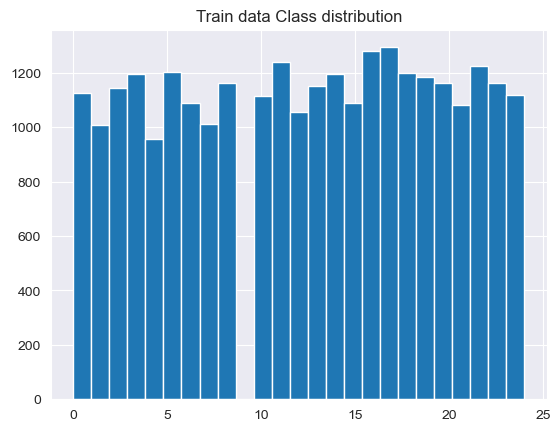

In [14]:
# reading in data

test_df = pd.read_csv('kaggleDataset/sign_mnist_test.csv')
train_df = pd.read_csv('kaggleDataset/sign_mnist_train.csv')

CLASS_COL = 'label'

print(f"Train data shape: {train_df.shape}, Test data shape: {test_df.shape}")

plt.title("Train data Class distribution")
plt.hist(train_df.label, bins=25)
plt.show()

In [3]:
features, labels = dataframe_to_array(train_df)

In [17]:
# splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

# fitting a basic nb model
clf = MultinomialNB()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

score = round(clf.score(X_test, y_test), 4)

### Initial Results:

Simply training and evaluating NB model on test data results in accuracy of :

In [18]:
print(score)  # initial accuracy

0.5394


### Cropping Image without resizing:

We will attempt to crop the pixel vector uniformly. Meaning, reducing a layer of pixels around the image one by one and visualizing the resulting accuracies. We will crop the entire dataset in this manner and visualize the resulting accuracies without resizing, while implementing k fold cross validation to compare different magnitudes of size reductions. The intuition here is to eliminate background pixels that may affect probabilities.

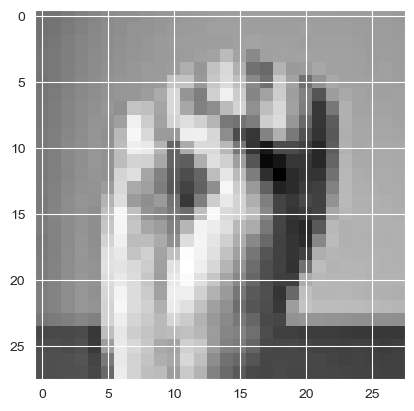

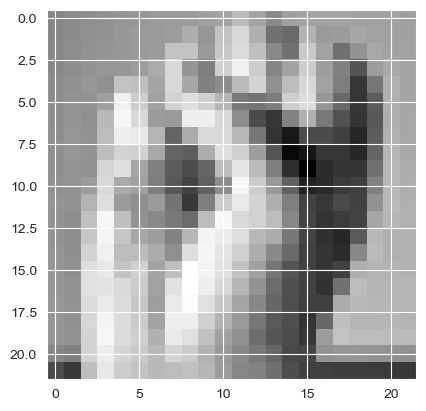

In [23]:
# trying to filter out background pixels

utils.render_row(features[10])
row_filtered = crop_pixel_row(features[10])
utils.render_row(row_filtered)

In [8]:
# k fold cross validation tuning by reducing layers of pixels

cropSizes = list(range(10))
scores = []
k = 5

for cropSize in cropSizes:
    fold_scores = []
    filtered_x = apply_crop(X_train, crop_size=cropSize)
    for i in range(k):
        split_x = np.array([filtered_x[j] for j in range(len(filtered_x)) if j % k != i])
        split_y = np.array([y_train[j] for j in range(len(y_train)) if j % k != i])
        validation_split_x = np.array([filtered_x[j] for j in range(len(filtered_x)) if j % k == i])
        validation_split_y = np.array([y_train[j] for j in range(len(y_train)) if j % k == i])

        score = do_nb(split_x, split_y, validation_split_x, validation_split_y)
        fold_scores.append(score)
    scores.append(np.mean(fold_scores))

bestCropSize = cropSizes[np.argmax(scores)]


Best crop size: 3, Best Validation accuracy 0.565


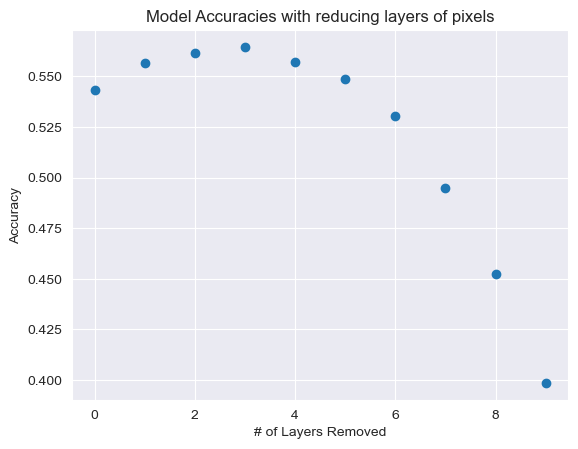

In [9]:
print(f"Best crop size: {bestCropSize}, Best Validation accuracy {round(max(scores), 3)}")
plt.title("Model Accuracies with reducing layers of pixels")
plt.xlabel('# of Layers Removed')
plt.ylabel("Accuracy")
plt.scatter(cropSizes, scores)

In [10]:
# applying best model parameters to a test set

# best cropsize is 3
filtered_x_train = apply_crop(X_train, crop_size=bestCropSize)
filtered_x_test = apply_crop(X_test, crop_size=bestCropSize)
best_test_accuracy = round(do_nb(filtered_x_train, y_train, filtered_x_test, y_test), 3)

print(f"Best test accuracy: {best_test_accuracy}")


Best test accuracy: 0.553


### Random Crop Image Augmentation

We will attempt to randomly crop the images with a fixed crop size and then resize them back to original dimensions. Algorithm basically chooses a random point to begin crop from and generates a cropped image based on some crop_width and crop_height. This experiment will only do square crops. Will use k-fold cross validation to test different sizes. keep in mind original images are 28x28

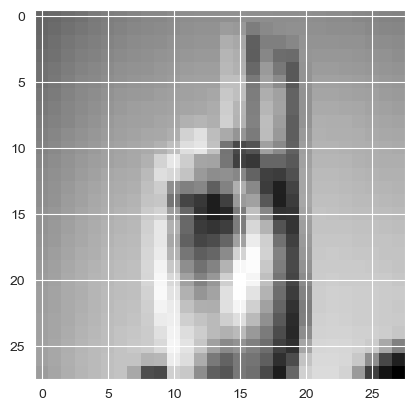

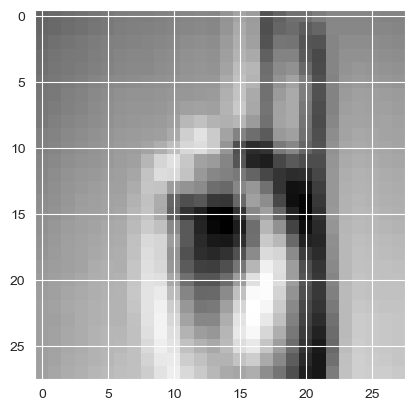

In [24]:
# random image crop augmentation

row = features[rnd.randint(1, len(features))]
plt.imshow(row_to_img_grid(row), cmap='gray')
plt.show()
test_crop = random_crop(row_to_img_grid(row), 23, 23)
plt.imshow(test_crop, cmap='gray')
plt.show()

In [33]:
cropSizes = list(range(1,28))
scores = []
k = 5

for cropSize in cropSizes:
    fold_scores = []
    filtered_x = apply_random_image_crop(X_train, cropSize, cropSize)
    for i in range(k):
        split_x = np.array([filtered_x[j] for j in range(len(filtered_x)) if j % k != i])
        split_y = np.array([y_train[j] for j in range(len(y_train)) if j % k != i])
        validation_split_x = np.array([X_train[j] for j in range(len(X_train)) if j % k == i])
        validation_split_y = np.array([y_train[j] for j in range(len(y_train)) if j % k == i])

        score = do_nb(split_x, split_y, validation_split_x, validation_split_y)
        fold_scores.append(score)
    scores.append(np.mean(fold_scores))

bestCropSize = cropSizes[np.argmax(scores)]

Best crop size: 27, Best Validation accuracy 0.531


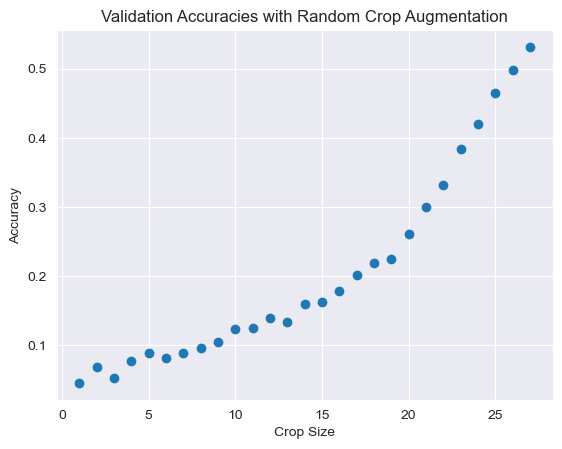

In [34]:
print(f"Best crop size: {bestCropSize}, Best Validation accuracy {round(max(scores), 3)}")
plt.title("Validation Accuracies with Random Crop Augmentation")
plt.xlabel('Crop Size')
plt.ylabel("Accuracy")
plt.scatter(cropSizes, scores)

In [35]:
# random crop image for model

cropped_train = apply_random_image_crop(X_train, bestCropSize, bestCropSize)
best_random_crop_acc = do_nb(cropped_train, y_train, X_test, y_test)

print(f"Best random crop test accuracy : {round(best_random_crop_acc, 4)}")

Best random crop test accuracy : 0.5254
